# Longitudinal Analysis 3

Analyze the longitudinal volumes that were produced by running HIPS-THOMAS directly on each time point (after registering each time point to a subject template). This is in contrast to `longitudinal_analysis1.ipynb` and `longitudinal_analysis1.ipynb`, which used the Jacobian approach.

In [1]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("error")


from mri_data import file_manager as fm

In [ ]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
work_home = drive_root / "srs-9/longitudinal"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
date_format = "%Y%m%d"
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv",
                              index_col="subid").dropna()

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv("/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", 
                              index_col="index")
hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)
hips_thomas_ref = pd.Series(hips_thomas_ref['struct_name'])
main_index = hips_thomas_ref.index[~hips_thomas_ref.index.isin([1, 33, 34])]

hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']

with open(dataroot / "subject-sessions-longit.json", 'r') as f:
    subject_sessions = json.load(f)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT2.csv", index_col="subid")
choroid_dists["1"] = 4

ventricle_dists = pd.read_csv(data_dir / "centroid-ventricle_SDT.csv", index_col="subid")
ventricle_dists["1"] = 4

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")
df_clinical = pd.read_csv("/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid")
df_clinical = df_clinical.join([choroid_volumes, tiv])

viridis = colormaps['viridis'].resampled(20)

all_subjects = []
for folder in work_home.glob("sub*"):
    if len(list((folder / "left").glob("*.csv"))) > 0 and len(list((folder / "right").glob("*.csv"))) > 0:
        all_subjects.append(re.match(r"sub(\d{4})", folder.name)[1])
    else:
        print(folder)
# all_subjects.remove("1064")
all_subids = [int(sub) for sub in all_subjects]

choroid_changes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_longitudinal_changes.csv", index_col="subid")
choroid_changes['abs_change'] = choroid_changes['volume2'] - choroid_changes['volume1']
choroid_changes['norm_change'] = choroid_changes['abs_change'] / choroid_changes['t_delta']

mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv", index_col="index")

long_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/longitudinal/mean_volumes3.csv", index_col="subid")


/mnt/h/srs-9/longitudinal/sub1341
/mnt/h/srs-9/longitudinal/sub2015


In [6]:
def get_subject_data(subid):
    sessions = sorted(subject_sessions[subid])
    work_dir = work_home / f"sub{subid}"

    index = hips_thomas_ref.index[~hips_thomas_ref.index.isin([34, 33])]
    session_volumes = defaultdict(list)
    # just copy first and last to speed things up
    sessions = sorted(sessions)
    sessions = [sessions[0], sessions[-1]]
    for sesid in sessions:
        ses_dataL = pd.read_csv(work_dir / "left" / f"hipsthomas_full_jacobianinv-{sesid}.csv", index_col="struct")
        ses_dataR = pd.read_csv(work_dir / "right" / f"hipsthomas_full_jacobianinv-{sesid}.csv", index_col="struct")
        vols = []
        for i in index:
            left_vol = ses_dataL.loc[i, 'volumes'] / ses_dataL.loc[i, 'jac_det']
            right_vol = ses_dataR.loc[i, 'volumes'] / ses_dataR.loc[i, 'jac_det']
            vols.append(left_vol+right_vol)
            # vols.append(left_vol)
        session_volumes[sesid] = vols

    df = pd.DataFrame(session_volumes, index=index)
    data = pd.DataFrame({}, index=df.index)
    for ind in data.index:
        data.loc[ind, 'choroid_dist'] = choroid_dists.loc[int(subid), str(ind)]
        data.loc[ind, 'ventricle_dist'] = ventricle_dists.loc[int(subid), str(ind)]
    # data['choroid_dist'] = choroid_dists.loc[int(subid), :].tolist()
    # data['ventricle_dist'] = ventricle_dists.loc[int(subid), :].tolist()
    changes = [(row[sessions[-1]] - row[sessions[0]])/row[sessions[0]] for _,row in df.iterrows()]
    # changes = [(row[sessions[-1]]/row[sessions[0]]) for _,row in df.iterrows()]

    # changes = [change / max([np.abs(max(changes)), np.abs(min(changes))]) for change in changes]
    data['change'] = changes
    data['vol1'] = vols[0]
    data['vol2'] = vols[1]

    delta = datetime.strptime(str(df.columns[-1]), date_format) - datetime.strptime(str(df.columns[0]), date_format)
    t_delta = delta.days / 365

    return {'data': data, 't_delta': t_delta}


def proc_subject(row: pd.Series):
    delta = datetime.strptime(str(int(row.time2)), date_format) - datetime.strptime(str(int(row.time1)), date_format)
    t_delta = delta.days / 365
    row['t_delta'] = t_delta
    for i in main_index:
        struct_name = hips_thomas_ref[i]
        v1 = row[f"{struct_name}_time1"]
        v2 = row[f"{struct_name}_time2"]
        try:
            row[f"{struct_name}_change"] = (v2 - v1) / v1
        except RuntimeWarning:
            print(i)
    return row


In [42]:
hips_thomas_invref['AV_2']

2

In [ ]:
subjects = [int(subid) for subid in all_subjects if df_clinical.loc[int(subid), "dz_type2"] == "MS"]

long_data = pd.concat(
    [proc_subject(long_volumes.loc[subid, :]).to_frame().T for subid in subjects if subid in long_volumes.index]
)
long_data

ValueError: No objects to concatenate

In [10]:
all_subjects

[]

In [33]:
mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
                                index_col="index")

mean_vals = long_data.mean()
mean_vals

time1               2.016810e+07
THALAMUS_1_time1    4.422513e+03
AV_2_time1          4.409740e+01
VA_4_time1          2.473766e+02
VLa_5_time1         7.690260e+01
                        ...     
Cla_28_change      -2.205420e-02
GPe_29_change       4.963182e-03
GPi_30_change       2.444587e-03
Put_31_change      -1.042159e-03
RN_32_change       -2.044288e-02
Length: 66, dtype: float64

In [47]:
plot_data = {"struct_name": [], "dist": [], "change": []}
for val in hips_thomas_ref[main_index]:
    i = hips_thomas_invref[val]
    plot_data['struct_name'].append(val)
    plot_data['dist'].append(mni_dists.loc[i, 'left_exposure'])
    plot_data['change'].append(mean_vals[f"{val}_change"])

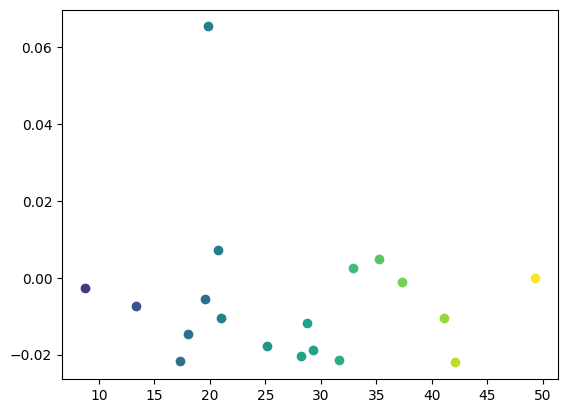

In [52]:
max_dist = max(plot_data['dist'])
for i in range(len(plot_data['struct_name'])):
    x = plot_data['dist'][i]
    y = plot_data['change'][i]
    struct = plot_data['struct_name'][i]
    c = x / max_dist
    plt.scatter(x, y, color=viridis(c), label=struct)


In [38]:
mni_dists

,left_exposure,right_exposure
index,,
2,28.724859,28.201181
4,29.301275,28.637189
5,25.154024,24.134354
6,20.982216,20.271701
7,13.337370,12.456556
8,8.712833,8.349248
9,19.527532,18.583537
10,17.274308,16.610573
11,18.029122,17.492163


In [31]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists["1"] = 4
mean_dists = choroid_dists.mean()
mean_dists

2     31.843822
4     32.552127
5     27.551238
6     22.571814
7     14.288109
8      9.284092
9     21.386248
10    17.727606
11    18.934445
12    22.623915
13    20.989551
14    35.144391
26    56.210976
27    46.848935
28    47.748334
29    39.257438
30    36.676460
31    42.325215
32    30.266386
1      4.000000
dtype: float64

In [14]:
subjects

[1003,
 1017,
 1023,
 1038,
 1042,
 1065,
 1071,
 1076,
 1082,
 1094,
 1098,
 1107,
 1119,
 1125,
 1131,
 1152,
 1155,
 1161,
 1165,
 1167,
 1182,
 1198,
 1211,
 1218,
 1225,
 1235,
 1239,
 1240,
 1241,
 1248,
 1257,
 1293,
 1301,
 1318,
 1326,
 1341,
 1343,
 1358,
 1360,
 1364,
 1371,
 1376,
 1382,
 1396,
 1401,
 1417,
 1441,
 1442,
 1479,
 1508,
 1527,
 1529,
 1536,
 1544,
 1546,
 2001,
 2003,
 2006,
 2025,
 2026,
 2033,
 2039,
 2043,
 2048,
 2054,
 2075,
 2088,
 2106,
 2112,
 2113,
 2118,
 2119,
 2152,
 2171,
 2178,
 2195,
 2213,
 3021]

In [12]:
row

time1               2.017033e+07
THALAMUS_1_time1    4.530500e+03
AV_2_time1          3.450000e+01
VA_4_time1          2.255000e+02
VLa_5_time1         6.950000e+01
                        ...     
Cla_28_change      -1.543974e-01
GPe_29_change       3.016591e-03
GPi_30_change       1.008902e-01
Put_31_change       4.212228e-02
RN_32_change        7.352941e-03
Name: 1003, Length: 66, dtype: float64

In [ ]:
str(long_volumes.loc[1003, 'time1'])

pd.

'20170329.0'

In [14]:
hips_thomas_ref

index
1     THALAMUS_1
2           AV_2
4           VA_4
5          VLa_5
6          VLP_6
7          VPL_7
8          Pul_8
9          LGN_9
10        MGN_10
11         CM_11
12      MD_Pf_12
13         Hb_13
14        MTT_14
26        Acc_26
27        Cau_27
28        Cla_28
29        GPe_29
30        GPi_30
31        Put_31
32         RN_32
33         GP_33
34        Amy_34
Name: struct_name, dtype: object